Radek posted about this [here](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/309220), and linked to a GitHub repo with the code.

I just transferred that code here to Kaggle notebooks, that's all.

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore') # Ignore annoying warnings :-)

In [2]:
def apk(actual, predicted, k=12):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=12):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [3]:
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)

def calculate_apk(list_of_preds, list_of_gts):
    # for fast validation this can be changed to operate on dicts of {'cust_id_int': [art_id_int, ...]}
    # using 'data/val_week_purchases_by_cust.pkl'
    apks = []
    for preds, gt in zip(list_of_preds, list_of_gts):
        apks.append(apk(gt, preds, k=12))
    return np.mean(apks)

def eval_sub(sub_csv, skip_cust_with_no_purchases=True):
    sub=pd.read_csv(sub_csv)
    validation_set=pd.read_parquet('data/validation_ground_truth.parquet')

    apks = []

    no_purchases_pattern = []
    for pred, gt in zip(sub.prediction.str.split(), validation_set.prediction.str.split()):
        if skip_cust_with_no_purchases and (gt == no_purchases_pattern): continue
        apks.append(apk(gt, pred, k=12))
    return np.mean(apks)

### Parameters

In [4]:
KAGGLE = False               # Changes test week, validation, transaction max week, ...
DATA_DIR = "../data"        # Where the csv and parquet files are stored
SUB_DIR = "../submissions"  # Where the submission csv file will be stored

FB_QUANTILE = 0.90          # Changes the FB Treshold.
K_PRICE_SIMILARITIES = 50   # How many similarly prices articles are generated
K_ARTICLE_SIMILARITIES = 10 # How many similarly articles are generated

N_ESTIMATORS = 50           # Amount of estimator for frequent buyer model

### Read Data

In [5]:
transactions = pd.read_parquet(DATA_DIR + '/transactions_train.parquet', engine='pyarrow')
customers = pd.read_parquet(DATA_DIR + '/customers.parquet', engine='pyarrow')
articles = pd.read_parquet(DATA_DIR + '/articles.parquet', engine='pyarrow')

### Set validation and test week. Trim Transactions

In [6]:
# Create a validation set for the test week
if KAGGLE:
    val = transactions[transactions.week == transactions.week.max() + 1]
else:
    val = transactions[transactions.week == transactions.week.max()]

In [7]:
if KAGGLE:
    # Calculate the next week number after the current maximum week in the data
    test_week = transactions.week.max() + 1

    # Filter the transactions to include only those from the last 10 weeks
    transactions = transactions[transactions.week > transactions.week.max() - 10]
else:
    # Set test week to the last available week
    test_week = transactions.week.max()

    # Filter the transactions to include only those from the last 10 weeks and make sure the test week is not in it!
    transactions = transactions[transactions.week > transactions.week.max() - 10]
    transactions = transactions[transactions.week < transactions.week.max()]

print("Test week: ", test_week)
print("Transactions weeks: [", transactions.week.min(), "-", transactions.week.max(), "]", "= ", transactions.week.max() - transactions.week.min() ,"weeks of data")

Test week:  104
Transactions weeks: [ 95 - 103 ] =  8 weeks of data


# Generating candidates

### Last purchase candidates

In [8]:
%%time

# Create a mapping of each customer --> weeks in which they have made transactions
c2weeks = transactions.groupby('customer_id')['week'].unique()

CPU times: user 6.46 s, sys: 51.9 ms, total: 6.51 s
Wall time: 6.49 s


In [9]:
# Calculating the Date Range for Each Week
transactions.groupby('week')['t_dat'].agg(['min', 'max'])

,min,max
week,,
95,2020-07-15,2020-07-21
96,2020-07-22,2020-07-28
97,2020-07-29,2020-08-04
98,2020-08-05,2020-08-11
99,2020-08-12,2020-08-18
100,2020-08-19,2020-08-25
101,2020-08-26,2020-09-01
102,2020-09-02,2020-09-08
103,2020-09-09,2020-09-15


In [10]:
%%time

# Initialize an empty dictionary to store the mapping of current to next weeks for each customer
c2weeks2shifted_weeks = {}

# Iterate through each customer and their associated weeks
for c_id, weeks in c2weeks.items():
    # Initialize a sub-dictionary for each customer
    c2weeks2shifted_weeks[c_id] = {}

    # Iterate through the weeks, but stop one week early to avoid index error
    for i in range(weeks.shape[0] - 1):
        # Map the current week to the next week
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i + 1]

    # For the last week in the list, map it to the 'test_week' (a future week)
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

CPU times: user 266 ms, sys: 18.2 ms, total: 284 ms
Wall time: 283 ms


In [11]:
c2weeks2shifted_weeks[28847241659200]

{95: 96, 96: 101, 101: 102, 102: 104}

In [12]:
candidates_last_purchase = transactions.copy()

In [13]:
%%time

# Initialize an empty list to store the 'next' week for each transaction
weeks = []

# Iterate over each transaction, getting the customer ID and the week of the transaction
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    # For each transaction, append the 'next' week from the c2weeks2shifted_weeks dictionary
    # This 'next' week is the week following the current transaction week for the customer
    weeks.append(c2weeks2shifted_weeks[c_id][week])

candidates_last_purchase.week = weeks

CPU times: user 3.07 s, sys: 39.6 ms, total: 3.11 s
Wall time: 3.11 s


### Bestsellers candidates

In [14]:
# Compute the average selling price of each article for each week.
mean_price = transactions.groupby(['week', 'article_id'])['price'].mean()

In [15]:
# Calculate the bestseller ranks for articles each week
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12) \
    .rename('bestseller_rank').astype('int8')

In [16]:
# Merge the 'sales' data (which contains bestseller ranks) with the 'mean_price' data
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()

# Increment the 'week' column by 1 in the merged dataframe
bestsellers_previous_week.week += 1

In [17]:
# Filter the 'bestsellers_previous_week' df for records where week = 96
bestsellers_previous_week.pipe(lambda df: df[df['week']==96])

,week,article_id,bestseller_rank,price
0,96,760084003,1,0.025094
1,96,866731001,2,0.024919
2,96,600886001,3,0.022980
3,96,706016001,4,0.033197
4,96,372860002,5,0.013193
5,96,610776002,6,0.008318
6,96,877278002,7,0.025036
7,96,547780003,8,0.024814
8,96,817354001,9,0.021913
9,96,827968001,10,0.016436


In [18]:
# Extract the first transaction of each customer for each week
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()


In [19]:
# Remove duplicate records from the 'transactions' dataframe,
transactions.drop_duplicates(['week', 'customer_id'])

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29064059,2020-07-15,1456826891333599,888294001,0.013542,1,95
29067103,2020-07-15,2133687643102426,843642001,0.042356,2,95
29027487,2020-07-15,6010692573790711,857812010,0.039661,1,95
29046403,2020-07-15,6171059100114610,815447007,0.006763,2,95
...,...,...,...,...,...,...
31521960,2020-09-15,18439897732908966680,794321007,0.061000,2,103
31531712,2020-09-15,18444276791873187543,867969008,0.033881,2,103
31539937,2020-09-15,18444799607866739422,909721003,0.042356,2,103
31543799,2020-09-15,18446250046654386343,869872006,0.033881,1,103


In [20]:
# Merge 'unique_transactions' dataframe with 'bestsellers_previous_week' dataframe
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week',
)

In [21]:
# Prepare a test dataset from the 'unique_transactions' dataframe

# First, remove duplicate entries for each customer
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)

# Set the 'week' column of the test dataset to 'test_week'
test_set_transactions.week = test_week

In [22]:
# Merge the 'test_set_transactions' dataframe with the 'bestsellers_previous_week' dataframe
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

In [23]:
# Concatenate 'candidates_bestsellers' with 'candidates_bestsellers_test_week'
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])

# Remove the 'bestseller_rank' column from the combined dataframe
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

# Similar Article Candidates

### Remove bulk buys

In [24]:
transactions_2 = transactions.copy()

print(f"DataFrame size original: {transactions.shape}")

# Drop duplicate rows, removes bulk buyes
transactions_2.drop_duplicates(subset=['customer_id', 'article_id', 'week'], keep='last', inplace=True)

print(f"DataFrame size after dropping duplicates: {transactions_2.shape}")

DataFrame size original: (2522561, 6)
DataFrame size after dropping duplicates: (2270166, 6)


### Calculate Frequent Buyers

In [25]:
# Counting transactions for each customer_id
transaction_counts = transactions_2['customer_id'].value_counts()

# Calculating the 00th quantile as the threshold
threshold = transaction_counts.quantile(FB_QUANTILE)
print("frequent buyer threshold: ", threshold)

# Labeling frequent buyers in the transactions DataFrame
transactions_2['frequent_buyer'] = transactions_2['customer_id'].map(lambda x: transaction_counts[x] > threshold)

# Counting unique frequent buyers
num_frequent_buyers = transactions_2[transactions_2['frequent_buyer']]['customer_id'].nunique()
print(f"Number of frequent buyers: {num_frequent_buyers}")

# Filtering transactions for frequent buyers
frequent_buyer_transactions = transactions_2[transactions_2['frequent_buyer']]

# Merging with articles data
frequent_transactions = frequent_buyer_transactions.merge(articles[['article_id', 'product_group_name', 'product_type_name', 'colour_group_name']], on='article_id', how='left')

# Extract unique frequent buyer IDs
unique_frequent_buyers = list(frequent_buyer_transactions['customer_id'].unique())

frequent buyer threshold:  12.0
Number of frequent buyers: 36999


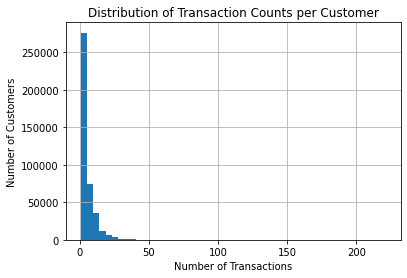

In [26]:
transaction_counts.hist(bins=50)
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.title('Distribution of Transaction Counts per Customer')
plt.show()

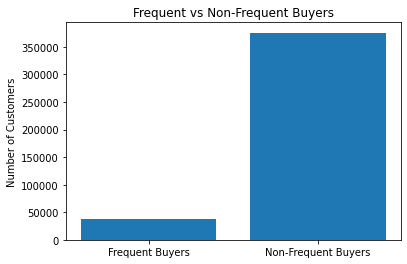

In [27]:
num_infrequent_buyers = transactions['customer_id'].nunique() - num_frequent_buyers
plt.bar(['Frequent Buyers', 'Non-Frequent Buyers'], [num_frequent_buyers, num_infrequent_buyers])
plt.ylabel('Number of Customers')
plt.title('Frequent vs Non-Frequent Buyers')
plt.show()

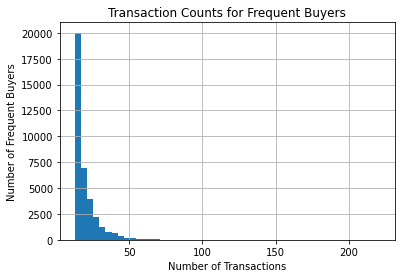

In [28]:
frequent_buyer_transaction_counts = frequent_buyer_transactions['customer_id'].value_counts()
frequent_buyer_transaction_counts.hist(bins=50)
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Frequent Buyers')
plt.title('Transaction Counts for Frequent Buyers')
plt.show()

### Prune Frequent Transactions & Articles

In [29]:
# List of Columns to remove
columns_to_remove = ['sales_channel_id', 'price', 'week', 'frequent_buyer']

# Drop certain columns, as we only need to use it to calculate similarities
pruned_frequent_transactions = frequent_transactions.copy()

# Drop the columns
pruned_frequent_transactions.drop(columns_to_remove, axis=1, inplace=True)

In [30]:
# List of columns to keep
columns_to_keep = ["product_type_name", "product_group_name", "article_id", "colour_group_name"]

# Getting the list of columns to drop
columns_to_drop = articles.columns.difference(columns_to_keep)

# Dropping the columns
pruned_articles = articles.drop(columns_to_drop, axis=1)

### Calculate Least bought categories

In [31]:
# Calculate the least common product group for each customer
least_common_categories = pruned_frequent_transactions.groupby('customer_id')['product_group_name'].apply(lambda x: x.value_counts().nsmallest(1).index.tolist())

# Calculate the least common product type for each customer
least_common_product_types = pruned_frequent_transactions.groupby('customer_id')['product_type_name'].apply(lambda x: x.value_counts().nsmallest(1).index.tolist())

# Calculate the least common colors for each customer
least_common_colors = pruned_frequent_transactions.groupby('customer_id')['colour_group_name'].apply(lambda x: x.value_counts().nsmallest(1).index.tolist())

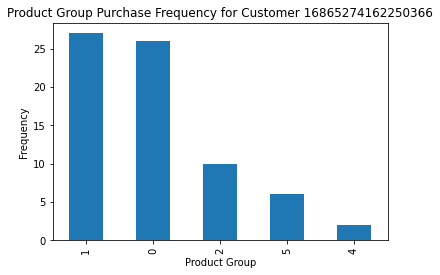

In [32]:
# Extract the first customer's ID
first_customer_id = unique_frequent_buyers[6]

# Filter the transactions of the first customer
first_customer_transactions = pruned_frequent_transactions[pruned_frequent_transactions['customer_id'] == first_customer_id]

# Count the occurrences of each product group for this customer
product_group_counts = first_customer_transactions['product_group_name'].value_counts()

# Plotting
product_group_counts.plot(kind='bar')

plt.xlabel('Product Group')
plt.ylabel('Frequency')
plt.title(f'Product Group Purchase Frequency for Customer {first_customer_id}')
plt.show()

### Get all outlier articles for each customer

In [33]:
# First, calculate the popularity of each article in frequent_buyer_transactions
article_popularity = frequent_buyer_transactions['article_id'].value_counts()
article_candidate_ids = {}
pruned_articles = articles.copy() # Test of dees moet?

for customer in unique_frequent_buyers:
    # Initialize an empty set for the customer
    article_candidate_ids[customer] = set()

    # Filter and keep only the most popular article for group_name-color combination
    matching_category_color = pruned_articles[
        (pruned_articles['product_group_name'] == least_common_categories[customer][0]) &
        (pruned_articles['colour_group_name'] == least_common_colors[customer][0])
    ]
    matching_category_color = matching_category_color[matching_category_color['article_id'].isin(article_popularity.index)]
    matching_category_color['popularity'] = matching_category_color['article_id'].map(article_popularity)
    matching_category_color = matching_category_color.sort_values(by='popularity', ascending=False).head(1)

    # Filter and keep only the most popular article for product type-color combination
    matching_product_type_color = pruned_articles[
        (pruned_articles['product_type_name'] == least_common_product_types[customer][0]) &
        (pruned_articles['colour_group_name'] == least_common_colors[customer][0])
    ]
    matching_product_type_color = matching_product_type_color[matching_product_type_color['article_id'].isin(article_popularity.index)]
    matching_product_type_color['popularity'] = matching_product_type_color['article_id'].map(article_popularity)
    matching_product_type_color = matching_product_type_color.sort_values(by='popularity', ascending=False).head(1)

    # Combine the results and add the found article IDs to the set for this customer
    combined_articles = pd.concat([
        matching_category_color,
        matching_product_type_color
    ]).drop_duplicates('article_id')

    article_candidate_ids[customer].update(combined_articles['article_id'].unique())

### Similarity Matrix w Cosine Similarity

In [34]:
def generate_item_similarities(articles, outlier_article_ids, k=10):
    # Features list to consider
    features = ['product_type_name', 'colour_group_name', 'product_group_name', 'garment_group_name' ]

    # Convert the integer categorical features to 'category' data type first
    for feature in features:
        articles[feature] = articles[feature].astype('category')

    # One-hot encoding
    articles_encoded = pd.get_dummies(articles, columns=features)

    # Filter articles to include only those in outlier_article_ids
    filtered_articles = articles_encoded[articles_encoded['article_id'].isin(outlier_article_ids)]

    # Normalize the one-hot encoded features
    scaler = StandardScaler()
    encoded_feature_names = list(set(articles_encoded.columns) - set(['article_id']))
    normalized_features = scaler.fit_transform(filtered_articles[encoded_feature_names])

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(normalized_features)

    # Store the k most similar articles for each outlier article
    similar_articles_dict = {}
    for idx, article_id in enumerate(filtered_articles['article_id']):
        similar_indices = similarity_matrix[idx].argsort()[-k-1:-1][::-1]
        similar_article_ids = [filtered_articles.iloc[i]['article_id'] for i in similar_indices]
        similar_articles_dict[article_id] = similar_article_ids

    return similar_articles_dict, similarity_matrix

### Generate similar items for each customer

In [35]:
# Collect all unique outlier article IDs
all_outlier_articles = set()
for articles_set in article_candidate_ids.values():
    all_outlier_articles.update(articles_set)

# Get the similarity Matrix
outlier_article_ids = list(all_outlier_articles)
similar_articles_dict, matrix = generate_item_similarities(articles, outlier_article_ids, K_ARTICLE_SIMILARITIES)

# Initialize a new dictionary to store the mapping from customer to similar articles
customer_to_similar_articles = {}

# Loop over each article candidate ids
for customer, outlier_articles in article_candidate_ids.items():
    # Initialize an empty set for the similar articles
    similar_articles_for_customer = set()

    # Iterate over each outlier article for this customer
    for outlier_article in outlier_articles:
        # Get the similar articles for this outlier
        similar_articles = similar_articles_dict.get(outlier_article, [])

        # Add these similar articles to the set
        similar_articles_for_customer.update(similar_articles)

    # Add the set of similar articles to the customer mapping
    customer_to_similar_articles[customer] = similar_articles_for_customer

### Generate 'Fake' Transactions

In [36]:
# Sort transactions by 't_dat' in descending order and then group by 'article_id'
sorted_transactions = transactions.sort_values(by='t_dat', ascending=False)
grouped_transactions = sorted_transactions.groupby('article_id')

synthetic_transactions_list = []

# Loop over customer_to_similar_articles
for customer, articlesss in customer_to_similar_articles.items():
    customer_transactions = []  # Temporary list for each customer's transactions
    for article in articlesss:
        # Get the latest transaction for each article
        if article in grouped_transactions.groups:
            latest_transaction = grouped_transactions.get_group(article).head(1).copy()
            # Update the customer_id
            latest_transaction['customer_id'] = customer
            customer_transactions.append(latest_transaction)

    synthetic_transactions_list.extend(customer_transactions)

# Concatenate all the transactions at once
synthetic_transactions = pd.concat(synthetic_transactions_list, ignore_index=True)

### Sanity Checks

In [37]:
backup_articles = pd.read_csv('../data/articles.csv') # Parquet files only has number values

# Iterating through the first 5 entries in similar_articles_dict
for original, similars in list(similar_articles_dict.items())[:10]:
    # Fetch and print details of the original article
    original_article = backup_articles[backup_articles['article_id'] == original]
    original_description = original_article['detail_desc'].values[0]
    original_color = original_article['colour_group_name'].values[0]
    original_product_type = original_article['product_type_name'].values[0]
    original_product_group = original_article['product_group_name'].values[0]

    print(f"Original Article ID: {original}")
    print(f"\tColor: {original_color}")
    print(f"\tProduct Type: {original_product_type}")
    print(f"\tProduct Group: {original_product_group}")
    print(f"\tDescription: {original_description}")

    # Optionally, print details of similar articles
    print("Similar Articles:")
    for similar in similars:
        similar_article = backup_articles[backup_articles['article_id'] == similar]
        similar_description = similar_article['detail_desc'].values[0]
        similar_color = similar_article['colour_group_name'].values[0]
        similar_product_type = similar_article['product_type_name'].values[0]
        similar_product_group = similar_article['product_group_name'].values[0]

        print(f"\tArticle ID: {similar}")
        print(f"\tColor: {similar_color}")
        print(f"\tProduct Type: {similar_product_type}")
        print(f"\tProduct Group: {similar_product_group}")
        print(f"\tDescription: {similar_description}\n")

Original Article ID: 126589010
	Color: Light Orange
	Product Type: Hair clip
	Product Group: Accessories
	Description: Plastic hair claws. Width 3.5 cm.
Similar Articles:
	Article ID: 214844001
	Color: Black
	Product Type: Hair clip
	Product Group: Accessories
	Description: Metal hair grips. Length 5 cm.

	Article ID: 214844002
	Color: Greyish Beige
	Product Type: Hair clip
	Product Group: Accessories
	Description: Metal hair grips. Length 5 cm.

	Article ID: 630675002
	Color: Light Beige
	Product Type: Hair clip
	Product Group: Accessories
	Description: Hair clips in coloured plastic.

	Article ID: 926520001
	Color: White
	Product Type: Hair clip
	Product Group: Accessories
	Description: Large hair claw in transparent plastic.

	Article ID: 214844003
	Color: Gold
	Product Type: Hair clip
	Product Group: Accessories
	Description: Metal hair grips. Length 5 cm.

	Article ID: 864822002
	Color: Silver
	Product Type: Hair clip
	Product Group: Accessories
	Description: Hammered metal hair c

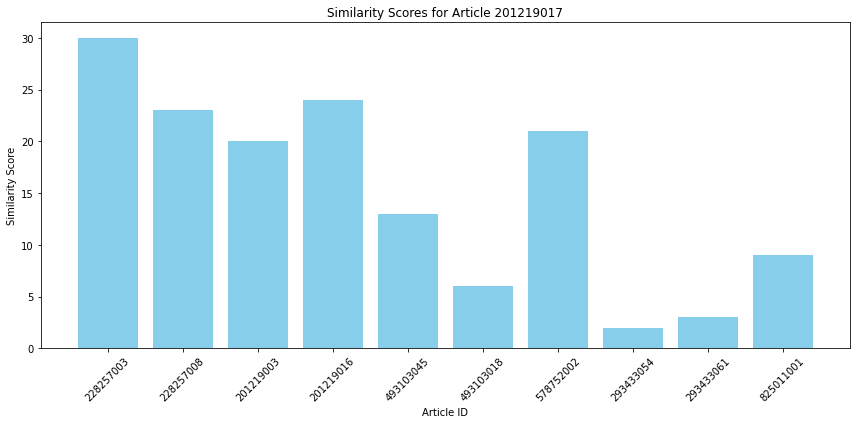

In [38]:
# Specific article ID
article_id = 201219017

# Check if the specific article is in the dictionary
if article_id in similar_articles_dict:
    # Get its most similar articles from the dictionary
    similar_articles = similar_articles_dict[article_id]

    # Retrieve their similarity scores from 'article_popularity', assuming it's a measure of similarity
    similarities = [article_popularity.get(a_id, 0) for a_id in similar_articles]

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(similar_articles)), similarities, color='skyblue')
    plt.xlabel('Article ID')
    plt.ylabel('Similarity Score')
    plt.title(f'Similarity Scores for Article {article_id}')
    plt.xticks(range(len(similar_articles)), similar_articles, rotation=45)
    plt.tight_layout()  # Adjust layout to fit the x-axis labels
    plt.show()
else:
    print(f"No similar articles found for article ID {article_id}")

In [39]:
if len(customer_to_similar_articles) == num_frequent_buyers:
    print("Every customer was processed!")
else:
    print("Oeps, not every customer was processed")

Every customer was processed!


# Combining transactions and candidates / negative examples

In [40]:
# Add a new column 'purchased' to the 'transactions' dataframe and set its value to 1
# This indicates that all rows in 'transactions' represent a purchase
transactions['purchased'] = 1
frequent_buyer_transactions['purchased'] = 1

In [42]:
# Data for non-frequent buyers
data = pd.concat(
    [transactions,
     candidates_last_purchase,
     candidates_bestsellers]
)

# Data for frequent buyers
data_frequent_buyers = pd.concat(
    [frequent_buyer_transactions,
     candidates_last_purchase,
     candidates_bestsellers,
     synthetic_transactions]
)

# Fill missing values in the 'purchased' column with 0
data.purchased.fillna(0, inplace=True)
data_frequent_buyers.purchased.fillna(0, inplace=True)

In [43]:
# Remove duplicate rows based on the combination of 'customer_id', 'article_id', and 'week'
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
data_frequent_buyers.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

### Add bestseller information

In [44]:
# Merge 'data' with 'bestsellers_previous_week' to add 'bestseller_rank' information
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

# Merge 'data_frequent_buyers' with 'bestsellers_previous_week' to add 'bestseller_rank' information
data_frequent_buyers = pd.merge(
    data_frequent_buyers,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [45]:
# Remove rows from the earliest week in the dataset
data = data[data.week != data.week.min()]
data_frequent_buyers = data_frequent_buyers[data_frequent_buyers.week != data_frequent_buyers.week.min()]

# Fill missing values in 'bestseller_rank' with 999
data.bestseller_rank.fillna(999, inplace=True)
data_frequent_buyers.bestseller_rank.fillna(999, inplace=True)

In [46]:
# Merge 'data' with additional information from the 'articles' and 'customers' datasets
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

# Merge 'data_frequent_buyers' with additional information from the 'articles' and 'customers' datasets
data_frequent_buyers = pd.merge(data_frequent_buyers, articles, on='article_id', how='left')
data_frequent_buyers = pd.merge(data_frequent_buyers, customers, on='customer_id', how='left')

In [47]:
# Sort the data by 'week' and 'customer_id'
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Sort the data for the frequent buyers by 'week' and 'customer_id'
data_frequent_buyers.sort_values(['week', 'customer_id'], inplace=True)
data_frequent_buyers.reset_index(drop=True, inplace=True)

In [48]:
# Split the data into 'train' and 'test' sets based on the week
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

# Split the frequent buyer data into 'train' and 'test' sets based on the week
train_frequent = data_frequent_buyers[data_frequent_buyers.week != test_week]
test_frequent = data_frequent_buyers[data_frequent_buyers.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [49]:
# Count the number of articles per customer per week in the training set
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values
train_baskets_frequent = train_frequent.groupby(['week', 'customer_id'])['article_id'].count().values

In [50]:
# Select the columns to be used for training and testing the model
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [51]:
%%time

# Select features (X) and target variable (y) for the training set
train_X = train[columns_to_use]
train_y = train['purchased']
test_X = test[columns_to_use]

# Select features (X) and target variable (y) for the training set for frequent buyers
train_X_frequent = train_frequent[columns_to_use]
train_y_frequent = train_frequent['purchased']
test_X_frequent = test_frequent[columns_to_use]

CPU times: user 193 ms, sys: 522 ms, total: 715 ms
Wall time: 931 ms


# Model training

In [52]:
from lightgbm.sklearn import LGBMRanker

In [53]:
# Initialize an LGBMRanker model with specific parameters
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

ranker_frequent = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=N_ESTIMATORS,
    importance_type='gain',
    verbose=10
)

In [54]:
%%time

# Fit the ranker model on the training data
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)


# Fit the ranker model on the training data
ranker_frequent = ranker_frequent.fit(
    train_X_frequent,
    train_y_frequent,
    group=train_baskets_frequent,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.849315
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.152318
[LightGBM] [Debug] init for col-wise cost 0.104404 seconds, init for row-wise cost 0.130807 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 10205052, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.853398
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.152604
[LightGBM] [Debug] init for col-wise cost 0.054155 seconds, init for row-wise cost 0.120446 seconds
[LightGBM] [Info] A

In [55]:
# Print feature importances
for i in ranker_frequent.feature_importances_.argsort()[::-1]:print(columns_to_use[i], ranker_frequent.feature_importances_[i]/ranker_frequent.feature_importances_.sum())

bestseller_rank 0.864037070202934
article_id 0.03384581234160472
product_type_no 0.02633696105438038
garment_group_no 0.02126352125843914
colour_group_code 0.019571305509263403
department_no 0.01277807019500004
graphical_appearance_no 0.008316186073911706
perceived_colour_master_id 0.005539732929453138
perceived_colour_value_id 0.0033242713316451243
section_no 0.0032525492399258183
index_code 0.0011773700085763214
index_group_no 0.0005571498548662116
age 0.0
fashion_news_frequency 0.0
club_member_status 0.0
Active 0.0
FN 0.0
postal_code 0.0


# Calculate predictions

In [56]:
%time

# Predict using the standard model
test['preds'] = ranker.predict(test_X)
c_id2predicted_article_ids = test.sort_values(['customer_id', 'preds'], ascending=False).groupby('customer_id')['article_id'].apply(list).to_dict()

# Predict using the frequent buyer model
test_frequent['preds_frequent'] = ranker_frequent.predict(test_X_frequent)
c_id2predicted_article_ids_frequent = test_frequent.sort_values(['customer_id', 'preds_frequent'], ascending=False).groupby('customer_id')['article_id'].apply(list).to_dict()

# Retrieve the list of bestsellers from the last week in the 'bestsellers_previous_week' dataframe
bestsellers_last_week = bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


# Create submission

### Evaluation functions

In [57]:
def precision(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]

    correct_predictions = []
    for p in predicted:
        if p in actual:
            correct_predictions.append(p)

    return len(correct_predictions) / len(predicted)

def recall(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]

    correct_predictions = []
    for p in predicted:
        if p in actual:
            correct_predictions.append(p)

    return len(correct_predictions) / len(actual)

def precision12(actual, predicted, k=12):
    # Initialize a variable to store the sum of precision scores
    total_precision = 0

    # Iterate over each pair of actual and predicted lists
    for a, p in zip(actual, predicted):
        # Calculate precision for this pair
        prec = precision(a, p, k)

        # Add the precision to the total sum
        total_precision += prec

    # Calculate the mean precision score
    mean_precision = total_precision / len(actual)

    return mean_precision


def recall12(actual, predicted, k=12):
    # Initialize a variable to store the sum of recall scores
    total_recall = 0

    # Iterate over each pair of actual and predicted lists
    for a, p in zip(actual, predicted):
        # Calculate recall for this pair
        rec = recall(a, p, k)

        # Add the recall to the total sum
        total_recall += rec

    # Calculate the mean recall score
    mean_recall = total_recall / len(actual)

    return mean_recall


### Generate predictions for frequent AND non-frequent buyers. Combine the results

In [58]:
sub = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [59]:
# Split the submission DataFrame using temp_set
sub_frequent = sub[customer_hex_id_to_int(sub['customer_id']).isin(unique_frequent_buyers)]
sub_nonfrequent = sub[~customer_hex_id_to_int(sub['customer_id']).isin(unique_frequent_buyers)]

# Initialize prediction lists
preds_nonfrequent = []
preds_frequent = []

# Generate predictions for non-frequent buyers
for c_id in customer_hex_id_to_int(sub_nonfrequent.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds_nonfrequent.append(pred[:12])

# Generate predictions for frequent buyers
for c_id in customer_hex_id_to_int(sub_frequent.customer_id):
    pred_frequent = c_id2predicted_article_ids_frequent.get(c_id, [])
    pred_frequent = pred_frequent + bestsellers_last_week
    preds_frequent.append(pred_frequent[:12])

# Format predictions for submission
formatted_preds_nonfrequent = [' '.join(['0' + str(p) for p in ps]) for ps in preds_nonfrequent]
formatted_preds_frequent = [' '.join(['0' + str(p) for p in ps]) for ps in preds_frequent]

# Assign predictions back to the respective DataFrames
sub_nonfrequent['prediction'] = formatted_preds_nonfrequent
sub_frequent['prediction'] = formatted_preds_frequent

# Combine the predictions into a single DataFrame for submission
sub_combined = pd.concat([sub_frequent, sub_nonfrequent])

if KAGGLE:
    sub_name = 'all_outliers'
    sub_combined.to_csv(f'{SUB_DIR}/{sub_name}.csv.gz', index=False)

# Evaluate the results

### Translate customer hex id to int and make list of articles

In [60]:
if not KAGGLE:
    # Convert hexadecimal string IDs to integers in predictions
    sub_combined['customer_id_int'] = customer_hex_id_to_int(sub_combined['customer_id'])
    # Ensure predictions are in the correct format
    sub_combined['prediction_list'] = sub_combined['prediction'].apply(lambda x: x.split())

### Evaluation ONLY for frequent buyers

In [61]:
if not KAGGLE:
    positive_items_val = val.groupby(['customer_id'])['article_id'].apply(list)
    val_users = positive_items_val.keys()
    val_items = []
    pred_items = []

    # Assuming unique_frequent_buyers is a list or similar, convert it to a set for efficiency
    unique_frequent_buyers_set = set(unique_frequent_buyers)

    # Assuming val_users is a list or similar, convert it to a set
    val_users_set = set(val_users)

    only_frequent_buyers = val_users_set.intersection(unique_frequent_buyers_set)

    for user in only_frequent_buyers:
        val_items.append(positive_items_val[user])

        predicted = sub_combined[sub_combined['customer_id_int'] == user]['prediction_list'].iloc[0]
        pred_items.append(predicted)

    pred_items = [[int(article_id) for article_id in user_pred] for user_pred in pred_items]

    print("Evaluating Frequent buyers only:")
    print("\tMAP@12 Score: ", mapk(val_items, pred_items), "%")
    print("\tPrecision@12 Score: ", precision12(val_items, pred_items), "%")
    print("\tRecall@12 Score: ", recall12(val_items, pred_items), "%")

Evaluating Frequent buyers only:
	MAP@12 Score:  0.0350073501742895 %
	Precision@12 Score:  0.01875871687587175 %
	Recall@12 Score:  0.06784326428726536 %


### Evaluation for all buyers

In [62]:
if not KAGGLE:
    pred_items = []

    positive_items_val = val.groupby(['customer_id'])['article_id'].apply(list)
    val_users = positive_items_val.keys()
    val_items = []

    for i,user in tqdm(enumerate(val_users)):
        val_items.append(positive_items_val[user])

        predicted = sub_combined[sub_combined['customer_id_int'] == user]['prediction_list'].iloc[0]
        pred_items.append(predicted)

    pred_items = [[int(article_id) for article_id in user_pred] for user_pred in pred_items]

    print("Evaluating all buyers:")
    print("\tMAP@12 Score: ", mapk(val_items, pred_items), "%")
    print("\tPrecision@12 Score: ", precision12(val_items, pred_items), "%")
    print("\tRecall@12 Score: ", recall12(val_items, pred_items), "%")

68984it [00:36, 1902.50it/s]


Evaluating all buyers:
	MAP@12 Score:  0.023340402880729777 %
	Precision@12 Score:  0.009841654103367228 %
	Recall@12 Score:  0.04597593966966094 %


### Novelty Evaluation

In [63]:
# Count the occurrences of each article
article_counts = frequent_transactions['article_id'].value_counts()

# Normalize by the total number of transactions
total_transactions = len(frequent_transactions)
global_article_frequencies = (article_counts / total_transactions).to_dict()

In [64]:
def novelty_score(predicted_lists, global_item_frequencies):
    """ Calculate the novelty score for the recommended items.
    global_item_frequencies is a dictionary mapping item_ids to their overall frequency in the dataset.
    """
    novelty_scores = []
    for items in predicted_lists:
        list_novelty = np.mean([1 - global_item_frequencies.get(item, 0) for item in items])
        novelty_scores.append(list_novelty)
    return np.mean(novelty_scores)

In [65]:
# Calculate novelty scores using the global_article_frequencies
novelty = novelty_score(pred_items, global_article_frequencies)
print("Average Novelty Score:", novelty)

Average Novelty Score: 0.999509074215768
